In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from finesse.gaussian import HGMode
import scipy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation

import finesse
# finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

%config InlineBackend.figure_format='svg'
# %matplotlib widget

# %matplotlib notebook
# %matplotlib notebook  

In [2]:
N = 404
Nz = 202
potential_0 = np.zeros((N,N,Nz))

# yv, xv, zv = np.meshgrid(np.arange(N),np.arange(N),np.arange(N))
# mask1 = xv<1/3*N
# mask2 = (1/3*N<=xv)*(xv<2/3*N)
# mask3 = xv>=2/3*N

# potential_0 = np.where(mask1, (-1+yv/N*2), (1-yv/N*2))
# potential_0 = np.where(mask2, (1-yv/N*2), (-1+yv/N*2))

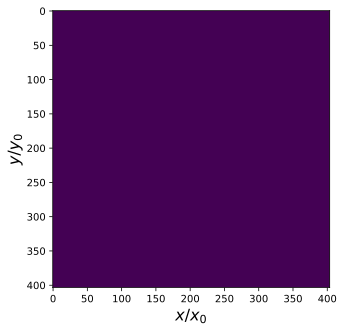

In [3]:
slc = Nz//2
fig, ax = plt.subplots(figsize=(7, 5))

# CS = ax.contour(np.arange(N)/N, np.arange(N)/N, potential_0[:,:,slc].T, levels=20)
# ax.clabel(CS, CS.levels, inline=True, fontsize=6)
ax.imshow(potential_0[:,:,slc].T)
ax.set_xlabel('$x/x_0$', fontsize=16)
ax.set_ylabel('$y/y_0$', fontsize=16)
plt.show()

In [4]:
kern = generate_binary_structure(3,1).astype(float)/6
kern[1,1,1] = 0
kern

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.16666667, 0.        ],
        [0.16666667, 0.        , 0.16666667],
        [0.        , 0.16666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]]])

In [5]:
size = 101
gap = 1
length = (size-gap*2)//3
index1 = length
index2 = index1 + gap
index3 = index2 + length
index4 = index3 + gap
print(0, index1, index2, index3, index4, 100)

0 33 34 67 68 100


In [105]:
gap = 1
def Dirichlet(sol, size=N, gap=gap):
    length = (size-gap*2)//3
    index1 = length
    index2 = index1 + gap
    index3 = index2 + length
    index4 = index3 + gap
    # print(index1, index2, index3, index4)
    
    sol[:index1, 0, :] = -1; sol[index2:index3, 0, :] = 1; sol[index4:, 0, :] = -1
    sol[:index1, -1, :] = 1; sol[index2:index3, -1, :] = -1; sol[index4:, -1, :] = 1

    # x and z edges
    # sol[0, :, :] = sol[-1, :, :] = 0
    # sol[:, :, 0] = sol[:, :, -1] = 0
    
    # between the electrodes
    # sol[index1:index2, 0, :] = 0; sol[index3:index4, 0, :] = 0
    # sol[index1:index2, -1, :] = 0; sol[index3:index4, -1, :] = 0
    
    return sol

def Neumann(sol, size=N, gap=gap):
    length = (size-gap*2)//3
    index1 = length
    index2 = index1 + gap
    index3 = index2 + length
    index4 = index3 + gap
    
    # x and z edges
    sol[0,:,:] = sol[1,:,:]; sol[-1,:,:] = sol[-2,:,:]
    sol[:,:,0] = sol[:,:,1]; sol[:,:,-1] = sol[:,:,-2]

    # between the electrodes
    sol[index1:index2, 0, :] = sol[index1:index2, 1, :]; sol[index3:index4, 0, :] = sol[index3:index4, 1, :]
    sol[index1:index2, -1, :] = sol[index1:index2, -2, :]; sol[index3:index4, -1, :] = sol[index3:index4, -2, :]
    
    return sol
# Dirichlet(potential,);

In [106]:
with open('./save/fieldpotential.npy', 'rb') as f:
    potential_0 = np.load(f)
print(potential_0.shape)

potential_0 = scipy.ndimage.zoom(potential_0, [4, 4, 1])
print(potential_0.shape)

(101, 101, 202)
(404, 404, 202)


In [107]:
error = []
iters = 100
potential = potential_0
Ey_sols = []
for i in range(iters):
    potential_updated = convolve(potential, kern, mode='constant')
    # Boundary conditions (Dirchlett & Neumann)
    potential_updated = Dirichlet(potential_updated)
    potential_updated = Neumann(potential_updated)

    # See what error is between consecutive arrays
    error.append(np.mean((potential-potential_updated)**2))
    potential = potential_updated

    if i%10 == 0:
        Ex, Ey, Ez = np.gradient(-potential[:,:,:])
        Ey = Ey[:,:, 50]
        Ey_sols.append(Ey)

    if i%30 == 0:
        print(f"{i} iterations have completed...")

Ey_sols = np.array(Ey_sols)

0 iterations have completed...
30 iterations have completed...
60 iterations have completed...
90 iterations have completed...


In [116]:
with open('./save/fieldpotential_new.npy', 'wb') as f:
    np.save(f, potential)

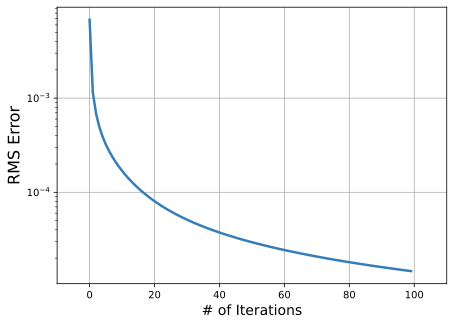

In [110]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.semilogy(np.sqrt(np.array(error)), lw=2.5, color=CB_color_cycle[0])
# plt.legend()
ax.set_xlabel('# of Iterations', fontsize=14)
ax.set_ylabel('RMS Error', fontsize=16);
ax.set_xlim([-10, 110]);
plt.grid()

In [112]:
Ey_sols.shape

(10, 404, 404)

In [115]:
start = 30
end = N - start
fig, ax = plt.subplots(figsize=(6, 5))
    
ax.set_xlabel('$x/x_0$', fontsize=16)
ax.set_ylabel('$y/y_0$', fontsize=16)
ax.set_aspect(1)

im = ax.pcolormesh(np.arange(start, end)/N, np.arange(start, end)/N, Ey_sols[0, start:end, start:end].T, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

cbar = fig.colorbar(im, cax=cax, orientation='vertical')
tbar = cbar.set_label(label="Ey", fontsize=16, rotation=90, labelpad=2)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

def animate(i):
    arr = Ey_sols[i, start:end, start:end].T
    vmax = np.max(arr)
    vmin = np.min(arr)
    im.set_array(arr)
    im.set_clim(vmin, vmax)
    ax.set_title(f"Iteration Steps: {i*5*10}", fontsize=12)
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

anim = animation.FuncAnimation(fig, animate, interval=100, frames=9,)
plt.close()
HTML(anim.to_jshtml())

In [11]:
# anim.save('animation_1.gif',)

In [6]:
with open('./save/fieldpotential_new.npy', 'rb') as f:
    potential = np.load(f)

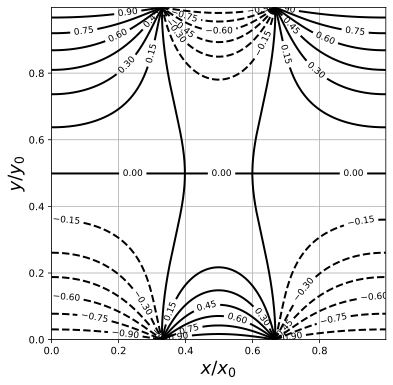

In [7]:
slc = Nz//2
fig, ax = plt.subplots(figsize=(6, 6))

CS = ax.contour(np.arange(N)/N, np.arange(N)/N, potential[:,:,slc].T, levels=15, colors='k', linewidths=2)
ax.clabel(CS, CS.levels, inline=True, fontsize=9)
ax.set_xlabel('$x/x_0$', fontsize=18)
ax.set_ylabel('$y/y_0$', fontsize=18)
plt.grid()
plt.show()

$$\Delta n\left(E_{y}\right)=\frac{1}{2} n_{e}^{3} r_{33} E_{y}$$
$$\Delta \phi = kL\Delta n\left(E_{y}\right)$$

In [8]:
ne = 1.7710
r33 = 35e-12 # Electro-optic coefficients pm/V e-12
epsilon_eff = 13 # Dielectric constant

k = 2*np.pi/(1064e-9)
voltage = 1 # 1 V
phi_factor = 1/2*ne**3*r33*k*voltage
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm
deltaz = 2*Lz/Nz
deltax = 2*Lx/N
phi_factor # w

0.0005740265403656434

In [9]:
Ex_, Ey_, Ez_ = np.gradient(-potential[:,:,:])
Ey = epsilon_eff*Ey_[:,:, 1:-1]/deltax
Ey.shape

(404, 404, 200)

In [10]:
start = N//4
end = N - start
zslice = Nz//2
# Ey_data_slice = scipy.ndimage.zoom(Ey[start:end, start:end, zslice], 10).T
Ey_data_slice = Ey[start:end, start:end, zslice].T
Ey_data_slice.shape

(202, 202)

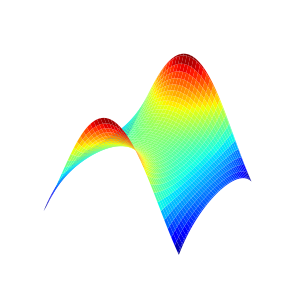

In [13]:
zslice = Nz//2
start = N//4
end = N - start

fig, ax = plt.subplots(figsize=(5,5), subplot_kw={"projection": "3d"})

X = np.arange(start, end)/N
Y = np.arange(start, end)/N
XX, YY = np.meshgrid(X, Y)

surf = ax.plot_surface(XX, YY,Ey_data_slice, cmap=cm.jet, linewidth=0, antialiased=False)
ax.set_xlabel('$x/x_0$', fontsize=16)
ax.set_ylabel('$y/y_0$', fontsize=16)
ax.set_axis_off()

In [14]:
R = Lx/2 # 1 mm, we zone in to half of the size to get the activate area
# w0 = R*.38
w0 = R*0.1 # The beam size 
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
print(q_0)

Beam_0 = HGMode(q_0, n=0, m=0)
x = y = np.linspace(-R, R, 201)
step = x[1] - x[0]
Beam_0_data = Beam_0.unm(x, y)

np.sum(np.conj(Beam_0_data)*Beam_0_data)*step**2

0.007381561686066242j
(126.32375554921293+0j)
1.0
(3.720075976020836e-44+0j)


(1.0000000000000049+0j)

In [15]:
Ey.shape

(404, 404, 200)

In [16]:
start = N//4
end = N - start

lenz = 200

R = Lx/2 # 2 mm 
w0 = R*0.1
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
zlim = Lz

def HG20_segments(num=10, interpolate=1, voltage=1):
    points = []
    step = 2/num
    point = -1+step/2
    points.append(point)
    for i in range(num-1):
        points.append(point+step)
        point = point+step

    rho_20s = []
    rho_02s = []
    grids = 202*interpolate
    x = y = np.linspace(-R, R, grids)

    for i in range(num):
        field_point = points[i]*zlim # the coordinates of the z location, from [-1, 1]
        start_z = int(i*lenz/num)
        end_z = int((i+1)*lenz/num)

        q_0 = np.pi*w0**2/(1064e-9)*1j + field_point # the beam parameter at the z location, from [-1, 1]
        
        HG_20 = HGMode(q_0, n=2, m=0)
        HG_20_data = HG_20.unm(x, y)

        HG_02 = HGMode(q_0, n=0, m=2)
        HG_02_data = HG_02.unm(x, y)

        Beam_0 = HGMode(q_0, n=0, m=0)
        Beam_0_data = Beam_0.unm(x, y)
        
        phi_data = scipy.ndimage.zoom(Ey[start:end, start:end, start_z:end_z].sum(axis=2), interpolate).T*deltaz # The OPD phase for the z slice
        # print(f"The number of data points along the z in this z slice is {end_z-start_z}")
        phi_data_norm = phi_data*phi_factor*voltage
        Beam_0_data_new = Beam_0_data*np.exp(1j*phi_data_norm)

        # rho_20 = np.sum(np.conj(HG_20_data)*Beam_0_data_new)/np.sum(np.conj(HG_20_data)*HG_20_data)
        
        rho_20 = np.sum(np.conj(HG_20_data)*Beam_0_data_new)/ \
                        np.sqrt(np.sum(np.conj(HG_20_data)*HG_20_data))/np.sqrt(np.sum(np.conj(Beam_0_data_new)*Beam_0_data_new))
        rho_20s.append(rho_20)

        rho_02 = np.sum(np.conj(HG_02_data)*Beam_0_data_new)/ \
                        np.sqrt(np.sum(np.conj(HG_02_data)*HG_02_data))/np.sqrt(np.sum(np.conj(Beam_0_data_new)*Beam_0_data_new))
        rho_02s.append(rho_02)

    return np.array(rho_20s), np.array(rho_02s)

In [17]:
voltages = np.linspace(1, 1e3, 10)
results_20s = []
results_02s = []
for voltage in voltages:
    HG20, HG02 = HG20_segments(num=10, interpolate=1, voltage=voltage)

    results_20s.append(HG20.sum())
    results_02s.append(HG02.sum())

(-21.208416479067687-28.551162351933066j)
319.7269304208243
(1.137425190525448e-18-3.229034210955956e-18j)
(90.93198055139916-43.02442704520541j)
1.0
(1.137425190525448e-18-3.229034210955956e-18j)
(90.93198055139916-43.02442704520541j)
1.0
(1.137425190525448e-18-3.229034210955956e-18j)
(-12.197923745208618-36.036051571705734j)
419.21011879253575
(1.2849380455925863e-23-4.4850149286020194e-24j)
(99.95253153007957-39.85702313656813j)
1.0
(1.2849380455925863e-23-4.4850149286020194e-24j)
(99.95253153007957-39.85702313656813j)
1.0
(1.2849380455925863e-23-4.4850149286020194e-24j)
(3.3435206902485337-40.5008962884912j)
546.3879623263272
(-1.307280938820249e-30+1.0825672478448164e-30j)
(109.88805908281373-33.713918746268035j)
1.0
(-1.307280938820249e-30+1.0825672478448164e-30j)
(109.88805908281373-33.713918746268035j)
1.0
(-1.307280938820249e-30+1.0825672478448164e-30j)
(24.475429870749515-35.339474576546586j)
684.5917646990378
(-5.059164034792279e-38-1.6928106156640616e-38j)
(119.329219517536

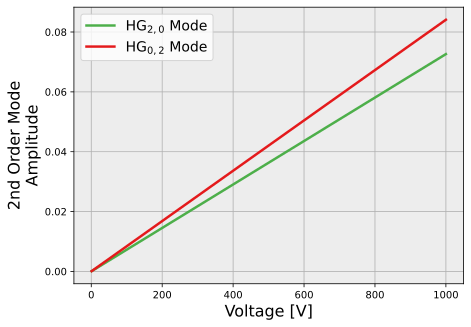

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)

ax.plot(voltages, np.abs(results_20s), lw=2.5, color=CB_color_cycle[2], label=r"$\mathrm{HG_{2,0}}$ Mode")
ax.plot(voltages, np.abs(results_02s), lw=2.5, color=CB_color_cycle[7], label=r"$\mathrm{HG_{0,2}}$ Mode")

ax.set_ylabel('2nd Order Mode\nAmplitude', fontsize=16)
ax.set_xlabel('Voltage [V]', fontsize=16)

# ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
# ax.set_xticks(range(0, 51, 10))

legend = ax.legend(fontsize=14, ncols=1, loc="best");